<a href="https://colab.research.google.com/github/UM-RMRS/raster_tools/blob/main/notebooks/ANF_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning and Spatial Modeling using raster_tools
Author John Hogland 3/29/2022

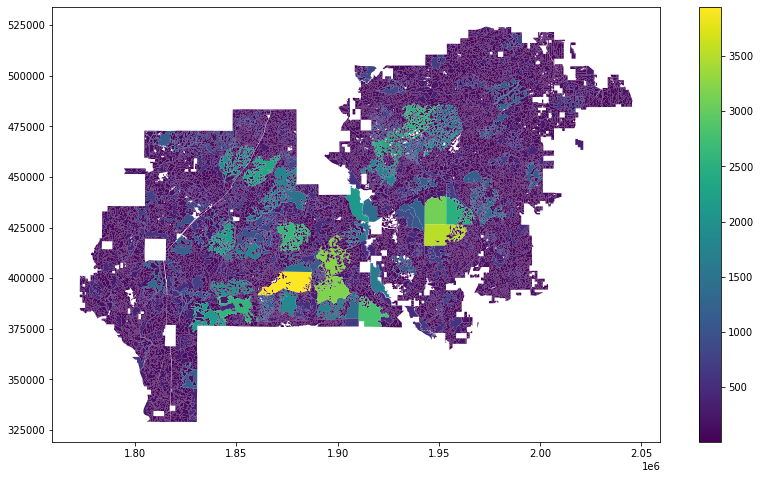

In this example we will use the stands of Apalachicola National Forest (ANF) and raster_tools to create spatial metrics, subset data into a training and validation dataset, create a predictive model, evaluate our model, and apply that model to the population of stands.  

## Installing raster_tools and update libraries

In [ ]:
!pip install --upgrade gdown
!pip install --upgrade numba
!pip install --upgrade geopandas
!pip install mapclassify
!pip install --upgrade datascience
!pip install --upgrade gym
!pip install --upgrade folium
!pip install raster_tools

## Download the data
These data consist of one polygon layer (ANFStands.shp) depicting the forested stands of ANF. 
Fields within the polygon layer include:
1. POLY_ID: row id
2. EV_CODE: environmental code
3. Forest_T_1: forest type 1
4. Class: vegetative class


In [ ]:
import gdown, zipfile

url='https://drive.google.com/file/d/1flAZzNiYDkdOuwvN0m4rfshOMgojXoGC/view?usp=sharing'
outfl= r'./ANF_Notebook_data.zip'
gdown.download(url=url,output=outfl,quiet=False,fuzzy=True)

with zipfile.ZipFile(outfl, 'r') as zip_ref:
    zip_ref.extractall(".")

## Import raster_tools and geopandas

In [ ]:
from raster_tools import open_vectors, Vector
import geopandas as gpd

## Specify path to data

In [ ]:
anf_path = './ANFStands.shp'
anf_df=open_vectors(anf_path)

## Look at the data

In [ ]:
print("Field Names = " + str(anf_df.field_names))
print("Projectoin Code = " + str(anf_df.crs))
print("ANF Stand Acres")
p1=anf_df.data.compute().plot(column='ACRES',legend=True,figsize=(14,8))
p1

### Exercise: Create a plot of ANF Stands showing the various vegetative classes (CLASS field)
- add a coding cell and modify the code to point to the 'CLASS' column
- create the plot

In [ ]:
# print("Field Names = " + str(anf_df.field_names))
# print("Projectoin Code = " + str(anf_df.crs))
# print("ANF Stand Class")
# p1=anf_df.data.compute().plot(column='Class',legend=True,figsize=(14,8))
# p1

## Create an interactive map and explore
- import folium
- simplify the geometry so we can view within Colab
- add in background layers (Tiled Services)
- explore

In [ ]:
import folium

#add our layers to the map
p1=anf_df.geometry.representative_point().compute().explore(color="red",name="Centroid")
#simplify so it will display within Colab. This will create slices and intersection does not change the underlying data.
p2=anf_df.geometry.simplify(20).compute().explore(m=p1,color="blue",name="ANF Stands")

#add ESRI's tiled imagery to potential base maps
folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Imagery',
        overlay = False,
        control = True
       ).add_to(p2)

#add layer controls to the map
folium.LayerControl().add_to(p2)

#show the interactive map
p2

### Exercise: Change the color of the polygons and centroids
- add a coding cell
- modify the code to invert the point and polygon colors
- explore

In [ ]:
# import folium

# #add our layers to the map
# p1=anf_df.geometry.representative_point().compute().explore(color="blue",name="Centroid")
# #simplify so it will display within Colab. This will create slices and intersection does not change the underlying data.
# p2=anf_df.geometry.simplify(20).compute().explore(m=p1,color="red",name="ANF Stands")

# #add ESRI's tiled imagery to potential base maps
# folium.TileLayer(
#         tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
#         attr = 'Esri',
#         name = 'Esri Imagery',
#         overlay = False,
#         control = True
#        ).add_to(p2)

# #add layer controls to the map
# folium.LayerControl().add_to(p2)

# #show the interactive map
# p2

# Describing the polygons based on their shape
## Create a series of functions that quantify shape complexity and that can be used to create predictor variables
- _redistribute_vertices
- calc_metrics
- _calc_all 
- stat_type class

In [ ]:
# Metrics
from shapely.geometry import MultiPoint, LineString
import numpy as np

def _redistribute_vertices(geom, distance):
    if geom.geom_type == 'LineString':
        num_vert = int(round(geom.length / distance))
        if num_vert == 0:
            num_vert = 1
        return LineString(
            [geom.interpolate(float(n) / num_vert, normalized=True)
             for n in range(num_vert + 1)])
    elif geom.geom_type == 'MultiLineString':
        parts = [_redistribute_vertices(part, distance)
                 for part in geom]
        return type(geom)([p for p in parts if not p.is_empty])
    else:
        raise ValueError('unhandled geometry %s', (geom.geom_type,))

def calc_metrics(gdf,mtype=8,smp=30):
    '''CalcMetric will calculate various spatial shape metrics for a given polygon
    gdf: geodataframe with polygon geometry
    mtype: statistic type (mean, var, sd, min, max, area, perimeter, perimeter to area, fractal, all) [0,1,2,3,4,5,6,7,8]
    
    returns: list of values for each row. If all is specified for mtype a list of shape metric value lists will be returned
    [[mean], [var], [sd], [min], [max], [area], [perimeter], [perimeter to area], [fractal]]
    '''
    geo=gdf.geometry
    outlst = []
    if(mtype==0):
        outlst=_calc_all(geo)[0]
    elif(mtype==1):
        outlst=_calc_all(geo)[1]
    elif(mtype==2):
        outlst=_cal_all(geo)[2]
    elif(mtype==3):
        outlst=_calc_all(geo)[3]
    elif(mtype==4):
        outlst=_calc_all(geo)[4]
    elif(mtype==5):
        outlst=_calc_all(geo)[5]
    elif(mtype==6):
        outlst=_calc_all(geo)[6]
    elif(mtype==7):
        outlst=_calc_all(geo)[7]
    elif(mtype==7):
        outlst=_calc_all(geo)[8]
    else:
        outlst=_calc_all(geo,smp)
    
    return outlst
        
def _calc_all(geo,smp=30):
    outlst=[[],[],[],[],[],[],[],[],[]]
    for g in geo.geometry:
        c_p = g.representative_point()
        lns=LineString(g.exterior.coords)
        if(smp!=None):
            lns=_redistribute_vertices(lns, smp)
        bnd_pnt = MultiPoint(lns.coords)
        min= np.inf
        max=0
        s=0
        ss=0
        n=0
        
        for p in bnd_pnt.geoms:
            d=c_p.distance(p)
            if(d>max):max=d
            if(d<min):min=d
            s+=d
            ss+=d*d
            n+=1
        outlst[0].append(s/n)
        var=(ss - ((s*s)/n))/(n-1)
        outlst[1].append(var)
        outlst[2].append(np.sqrt(var))
        outlst[3].append(min)
        outlst[4].append(max)
        a=g.area
        p=g.length
        outlst[5].append(a)
        outlst[6].append(p)
        outlst[7].append(p/a)
        outlst[8].append(np.log(a)/(np.log(p)+np.log(0.25)))
    
    return outlst

class stat_type():
    '''shape metrices'''
    MEAN = 0
    VAR = 1
    SD = 2
    MIN = 3
    MAX = 4
    AREA = 5
    PERIMETER = 6
    PA = 7
    FRACTAL= 8
    ALL = 9
 

## Look at the centroid, polygon boundary, vertices, and shape metrics for the first geometry

In [ ]:
from shapely.geometry import MultiPoint, MultiLineString, LineString, Point
import numpy as np, matplotlib.pyplot as plt
geo=anf_df.geometry[0].compute()
cp=geo.representative_point()
bndy=geo.boundary
p1=bndy.plot(figsize=(10,15))
p2=cp.plot(ax=p1,color='red',markersize=40)
p3=gpd.GeoSeries(Point(pnt[0],pnt[1]) for pnt in list(bndy[0].coords)).plot(ax=p2,color='blue',markersize=20)
print(_calc_all(geo,None))


## Look at centroid, polygon boundary, vertices, and shape metrics for the first geometry densified

In [ ]:

nbndy=gpd.GeoSeries(_redistribute_vertices(LineString(bndy[0]),100))
p1=nbndy.plot(figsize=(10,15))
p2=cp.plot(ax=p1,color='red',markersize=40)
p3=gpd.GeoSeries(Point(pnt[0],pnt[1]) for pnt in list(nbndy[0].coords)).plot(ax=p2,color='blue',markersize=20)
print(_calc_all(geo,100))

## Calculate shape metrics for all geometries densified 100 m 
- Shape metrics calculated: mean, var, sd, min, max, area, perimeter, perimeter to area, fractal. 
- This will take a little time to process the data (about 5 minutes).

In [ ]:
vls=calc_metrics(anf_df,mtype=stat_type.ALL,smp=100)
#should be a length of 9 (9 lists)
print(len(vls))

### Exercise: Determine the impact of densifing polygons
How much do the shape metrics change for the geo polygon using:
- 10 m densification
- 30 m densification
- 50 m densification

In [ ]:
# vls_10=_calc_all(geo,10)
# vls_30=_calc_all(geo,30)
# vls_50=_calc_all(geo,50)

# print(np.subtract(vls_10,vls_50))
# print(np.subtract(vls_10,vls_30))
# print(np.subtract(vls_30,vls_50))

# Preparing your data
## Add the shape metrics to the dask geopandas dataframe and create a new Vector object
- The output from calc_metrics function returns a list of shape metric lists. 
- Lists correspond to mean (0), var (1), sd (2), min (3), max (4), area (5), perimeter (6), perimeter to area (7), and fractal (8) values

In [ ]:
import pandas as pd
anf_df2=Vector(anf_df.data.assign(Mean=pd.Series(vls[0]),
                   Var=pd.Series(vls[1]),
                   Sd=pd.Series(vls[2]),
                   Min=pd.Series(vls[3]),
                   Max=pd.Series(vls[4]),
                   Area=pd.Series(vls[5]),
                   Pr=pd.Series(vls[6]),
                   Pa=pd.Series(vls[7]),
                   Fractal=pd.Series(vls[8])
                                 )
              )
anf_df2.data

## Split the data into random subsets used to train a model, test a model, and finally validate a model
- train sample size 5%
- test sample size 5%
- validation sample size 90%

In [ ]:
sub=anf_df2.data.sample(frac=0.10,random_state=12345)
train=sub.sample(frac=0.5,random_state=12345)
tid=train['POLY_ID']
sid=sub['POLY_ID']
check=sid.ne(tid)
test=sub[check]
did=anf_df2.data['POLY_ID']
check2=did.ne(sid)
val=anf_df2.data[check2]

### Exercise: spit the dataset into training, testing, and validation sizes of 10%, 10%, and 80%, respectively

In [ ]:
# sub10=anf_df2.data.sample(frac=0.20,random_state=12345)
# train10=sub10.sample(frac=0.5,random_state=12345)
# tid10=train10['POLY_ID']
# sid10=sub10['POLY_ID']
# check10=sid10.ne(tid10)
# test10=sub10[check10]
# did10=anf_df2.data['POLY_ID']
# check210=did10.ne(sid10)
# val10=anf_df2.data[check210]

# Modeling (Random Forest Classification)
## Create random forest functions using scikit learn
- random forest model: [sklearn link](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=random%20forest#sklearn.ensemble.RandomForestClassifier)
- store model
- open model
- predict new values

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import pickle
def rand_forest(train,resp,pred,trees=50,criterion='gini',n_jobs=-1,max_samples=0.66):
    '''This function is used to create a random forest model. 
    vector: vector object
    resp: response column name (string)
    pred: list of predictor varible column names (strings)
    trees: number of random forest trees
    criterion: gini or entropy
    n_jobs: number of processors to use when estimating the model (-1 = all)
    max_samples: proportion of input data to use to train each tree. 1-max_samples is used to evaluate each tree.
    
    returns a sklearn random forest model
    '''
    X = train[pred].to_dask_array().compute()
    fct=train[resp].compute().factorize()
    y = fct[0]
    mdl = RandomForestClassifier(n_estimators=trees,oob_score=True,random_state=0,criterion=criterion,n_jobs=n_jobs,max_samples=max_samples)
    mdl.fit(X,y)
    return [fct,mdl]   

def store_model(mdl,path):
    '''This function will serialize a model to disk
    inputs include a model (mdl) and a file path with extension (path)
   
    mdl: sklearn mdl
    path: the location to store the model
    '''
    s = pickle.dump(mdl,open(path, 'wb'))

def open_model(path):
    '''This function will read a serialized model (path) back into memory
    returns model.
    
    path: the path to the stored model
    
    returns: scklearn model
    '''
    mdl = pickle.load(open(path, 'rb'))
    return mdl
  
def predict_new_values(mdl, dgdf, pred):
    '''This function will predict the probability of each class for a new record from a random forest model (mdl) and predictor (pred) values 
    mdl: sklearn random forest model
    df: dataframe
    pred: predictor values [[0,0,0,0...]]
    returns list of class and probabilities, most likely class is located at [0]'''
    x=dgdf[pred].to_dask_array().compute()
    prb = mdl.predict_proba(x)
    return prb



## Create random forest model using our training dataset
- create the model (mdl)
- store the model (anf_veg_class.mdl)
- open the model (mdl2)
- look at OOBs (mdl, mdl2)

In [ ]:
pred=['Mean','Sd','Min','Max','Area','Pr','Pa','Fractal']
resp='Class'
fct,mdl=rand_forest(train,resp,pred)
mdl_path='anf_veg_class.mdl'
store_model(mdl,mdl_path)
mdl2=open_model(mdl_path)
print('OOB from mdl = ' + str(mdl.oob_score_))
print('OOB from mdl2 = ' + str(mdl2.oob_score_))

### Exercise: Create random forest models for your training dataset generated from 10% of the data
- Is there much difference in model accuracy?
- How can you tell?

In [ ]:
# pred=['Mean','Var','Sd','Min','Max','Area','Pr','Pa','Fractal']
# resp='Class'
# fct10,mdl10=rand_forest(train10,resp,pred)
# print('OOB from mdl = ' + str(mdl10.oob_score_))

## Predict class probabilities and calculate accuracy for the following datasets:
- test
- val
- anf_df.data 

In [ ]:
def get_estimation_dataframe(mdl,df,pred,clm_names):
    vls=predict_new_values(mdl,df,pred)
    odf=gpd.GeoDataFrame(data=vls)
    odf.columns = clm_names
    odf['MLC']=odf.idxmax(axis=1)
    odf['Class']=df['Class'].compute().values
    odf['Correct']=odf['MLC'].eq(odf['Class'])
    print('Accuracy = ' + str(odf['Correct'].sum()/odf.shape[0]))
    return odf

est_t=get_estimation_dataframe(mdl,test,pred,fct[1])
est_v=get_estimation_dataframe(mdl,val,pred,fct[1])
est_all=get_estimation_dataframe(mdl,anf_df2.data,pred,fct[1])

## Graph importance values for predictor variables

In [ ]:
imp=mdl.feature_importances_
v_imp = pd.Series(imp, index=pred)
fig, ax = plt.subplots(figsize=(14,8))
std = np.std([tree.feature_importances_ for tree in mdl.estimators_], axis=0)
v_imp.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## Graph accuracy by class

In [ ]:
#Class by Mapped Values
bvl=est_all['Correct'].astype('int').values
print("Overall Accuracy = " + str(np.round(bvl.sum()/len(bvl)*100,decimals=2))+ '\n')
mvl=est_all['MLC'].values
cvl=est_all['Class'].values
xtbl=pd.crosstab(cvl,mvl,dropna=False)
print(xtbl)
print()
xtbl.plot(kind='bar',title="MLC (col-0) vs Class (row_0)",figsize=(15,10),xlabel='Class',ylabel='Counts')

### Exercise: determine how unique the predictors are with one another
- look up [sklearn function for PCA](https://scikit-learn.org/stable/auto_examples/cross_decomposition/plot_pcr_vs_pls.html?highlight=correlation)
- Build a PCA for pred variables
- Report the proportion of information for each component
- if you have highly correlated predictors what does that do to your model?

In [ ]:
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler

# X=StandardScaler().fit_transform(train[pred].to_dask_array().compute())
# pca = PCA().fit(X)
# info_r=pca.explained_variance_ratio_
# print(info_r)

# fig,axes=plt.subplots(figsize=(20, 10),ncols=2,nrows=1,tight_layout=True)
# ax1=axes[0]
# ax2=axes[1]

# # figure one Proportion of correlation explained
# ax1.set_title("Proportion of correlation explained in each component",fontsize=24)
# ax1.bar(np.arange(len(info_r)),pca.explained_variance_ratio_)
# ax1.set_xlabel('Components',fontsize=24)
# ax1.set_ylabel("%",fontsize=24)
# ax1.set_ylim([0,1])

# # figure 2 component 1 by componet 2
# dft=pd.DataFrame(pca.transform(X))
# dft.columns =['comp1','comp2','comp3','comp4','comp5','comp6','comp7','comp8','comp9']
# dft2=dft.assign(Class=train['Class'])
# groups=dft2.groupby('Class')

# for name, group in groups:
#     ax2.plot(group.comp2,group.comp1,marker='o',markersize=4,linestyle='',label=name)
    
# ax2.legend()
# ax2.set_title('Comp 2 vs Comp 1 by Class',fontsize=24)
# ax2.set_xlabel('Comp1',fontsize=24)
# ax2.set_ylabel("Comp2",fontsize=24)
# # show the plot
# plt.show()

# Apply your Model to the population
## Merge est_all with anf_df2 and plot Pine class probabilities

In [ ]:
anf_df3=anf_df2.data.merge(est_all[['Pine','Hardwood','Pine Hardwood','Hardwood Pine','Non Forest','MLC']]).compute()
f, axes = plt.subplots(figsize=(20, 10), ncols=2, nrows=4,tight_layout=True)
cnt=0
for x in pred:
    anf_df3.plot(x=x,y='Pine',kind='scatter',ax=axes[cnt//2][cnt%2],)
    cnt+=1


## Explore MLC

In [ ]:
from folium import plugins
visdf=anf_df3.set_geometry(anf_df3.simplify(50))
p1=visdf.explore(color="red",name="MLC",column='MLC',style_kwds={'opacity':0.7})

#add ESRI's tiled imagery to potential base maps
folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Imagery',
        overlay = False,
        control = True
       ).add_to(p1)

#add layer controls to the map
folium.LayerControl().add_to(p1)

#add full screen to map
plugins.Fullscreen().add_to(p1)

#show the interactive map
p1

## Save to HTML file
This time we will not simplify. Once finished download the html file and view within your browser.

In [ ]:
p1=anf_df3.explore(color="red",name="MLC",column='MLC',style_kwds={'opacity':0.7})

#add ESRI's tiled imagery to potential base maps
folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Imagery',
        overlay = False,
        control = True
       ).add_to(p1)

#add layer controls to the map
folium.LayerControl().add_to(p1)

#add full screen to map
plugins.Fullscreen().add_to(p1)

#save the interactive map to google workspace and download
p1.save('mlc.html')

### Exercise: Build an interactive map for the population of estimated values from your model trained on 10% of the data.
- How different is the MLC?



In [ ]:
# est_all10=get_estimation_dataframe(mdl10,anf_df2.data,pred,fct10[1])
# anf_df4=anf_df2.data.merge(est_all10[['Pine','Hardwood','Pine Hardwood','Hardwood Pine','Non Forest','MLC']]).compute()

# p1=anf_df3.explore(name="MLC",column='MLC',style_kwds={'opacity':0.7})
# p2=anf_df4.explore(m=p1,name="MLC10",column='MLC',style_kwds={'opacity':0.7})

# #add ESRI's tiled imagery to potential base maps
# folium.TileLayer(
#         tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
#         attr = 'Esri',
#         name = 'Esri Imagery',
#         overlay = False,
#         control = True
#        ).add_to(p2)

# #add layer controls to the map
# folium.LayerControl().add_to(p2)

# #add full screen to map
# plugins.Fullscreen().add_to(p2)


# #show the interactive map to google workspace and download
# p2

# This ends the Machine Learning and Spatial Modeling using raster_tools short course

## Check out the other notebooks:
- https://github.com/UM-RMRS/raster_tools/blob/main/notebooks/tutorials.md

## References
- Raster-Tools GitHub: https://github.com/UM-RMRS/raster_tools
- Hogland's Spatial Solutions: https://sites.google.com/view/hoglandsspatialsolutions/home
- Dask: https://dask.org/
- Geopandas:https://geopandas.org/en/stable/
- Xarray: https://docs.xarray.dev/en/stable/
- Jupyter: https://jupyter.org/
- Anaconda:https://www.anaconda.com/
- VS Code: https://code.visualstudio.com/
- ipywidgets: https://ipywidgets.readthedocs.io/en/latest/
- numpy:https://numpy.org/
- matplotlib:https://matplotlib.org/
- folium: https://python-visualization.github.io/folium/
- pandas: https://pandas.pydata.org/
- sklearn: https://scikit-learn.org/stable/index.html